In [91]:
import datetime
from itertools import chain, combinations

import pandas as pd
import pyarrow as pa
import numpy as np
from utils import load_saved_data, get_connection, get_data
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, MSTL
#obtain hierarchical reconciliation methods and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace, ERM, Normality
from hierarchicalforecast.utils import aggregate

In [92]:
# df = load_saved_data()
# conn = get_connection()
# df = get_data(conn, 2018, 2018, 2_000_000, 0)
df = pd.read_feather("../data/2018.feather")

In [93]:
current_date = pd.Timestamp.now().normalize()
df = df.drop(df[df["closed_date"]>current_date].index)
df["borough"].fillna("Unspecified", inplace=True)

In [94]:
df.describe()

,created_date,closed_date,resolution_action_updated_date,latitude,longitude,due_date
count,1999999,1965899,1983911,1.854230e+06,1.854230e+06,913147
mean,2018-08-22 09:45:46.341392896,2018-09-09 20:00:57.793048576,2018-09-09 12:56:04.531892736,4.072587e+01,-7.392462e+01,2018-09-02 06:03:13.878392064
min,2018-04-13 18:06:41,2007-12-04 00:00:00,2013-05-17 00:00:00,4.049895e+01,-7.425495e+01,2018-04-13 19:07:03
25%,2018-06-19 00:18:28.500000,2018-06-26 11:17:00,2018-06-26 16:39:58.500000,4.066430e+01,-7.397041e+01,2018-06-24 05:16:25.500000
50%,2018-08-22 15:04:00,2018-09-02 08:50:00,2018-09-03 08:47:10,4.071663e+01,-7.392741e+01,2018-08-27 10:05:02
75%,2018-10-24 22:29:08.500000,2018-11-06 15:55:07,2018-11-07 10:52:21.500000,4.079664e+01,-7.387562e+01,2018-10-30 09:39:17.500000
max,2019-01-31 14:56:00,2024-02-12 11:40:56,2024-02-12 11:40:59,4.091294e+01,-7.370038e+01,2022-07-21 02:22:26
std,NaN,NaN,NaN,8.583189e-02,8.448542e-02,NaN


In [95]:
df[["latitude","borough"]].describe(include='all')

,latitude,borough
count,1854230.0,1999999
unique,<NA>,6
top,<NA>,BROOKLYN
freq,<NA>,635678
mean,40.725866,NaN
std,0.085832,NaN
min,40.498949,NaN
25%,40.664304,NaN
50%,40.716628,NaN
75%,40.796643,NaN


In [96]:
df[df["latitude"].isnull()]["borough"].unique()


<ArrowStringArray>
['QUEENS', 'BROOKLYN', 'BRONX', 'MANHATTAN', 'Unspecified', 'STATEN ISLAND']
Length: 6, dtype: string

In [97]:
df[(df["borough"]=="Unspecified") &  (df["latitude"].notnull())].count()

created_date                      2287
closed_date                       2285
agency                            2287
complaint_type                    2287
status                            2287
resolution_action_updated_date    2284
borough                           2287
descriptor                        2272
resolution_description            2272
incident_zip                      2144
city                              2251
latitude                          2287
longitude                         2287
due_date                          1814
bbl                                 40
dtype: int64

In [98]:
df[(df["borough"]=="Unspecified") &  (df["latitude"].isnull()) & (df["incident_zip"].isnull())].count()


created_date                      23770
closed_date                       21705
agency                            23770
complaint_type                    23770
status                            23770
resolution_action_updated_date    12954
borough                           23770
descriptor                        23584
resolution_description            23736
incident_zip                          0
city                                  8
latitude                              0
longitude                             0
due_date                          12982
bbl                                   0
dtype: int64

In [99]:
df = df[df["closed_date"]>df["created_date"]]

In [100]:
df["hours_to_complete"] =  pd.to_datetime(df["closed_date"]) - pd.to_datetime(df["created_date"])

In [101]:
# time_to_complete = pd.to_datetime(df["hours_to_complete"])
df['hours_to_complete'] = df["hours_to_complete"].astype("float64") / (3.6e12)
# df= df.drop("hours_to_update", axis=1)
# df = df.drop(df[df["hours_to_complete"]<0].index, axis=0)

In [102]:
df[(df["status"]!="Closed")].groupby("agency")["closed_date"].count()

agency
DEP       13
DOB      310
DOE        3
DOHMH      1
DOT        5
DPR       22
DSNY     981
TLC       14
Name: closed_date, dtype: int64[pyarrow]

<Axes: title={'center': 'Number of Unclosed Requests by Agency'}, xlabel='Agency', ylabel='Unclosed Request Count'>

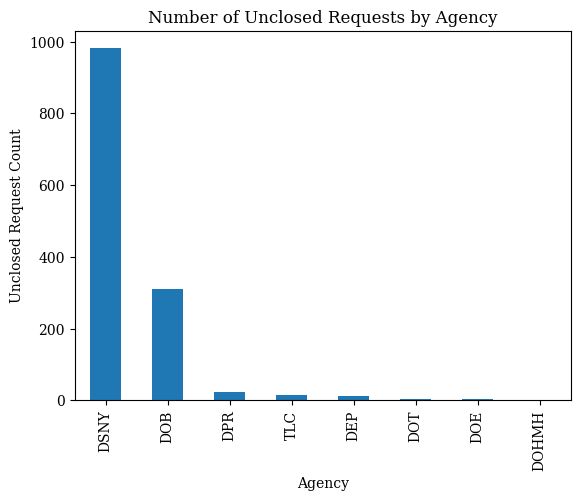

In [103]:
unclosed = df[(df["status"]!="Closed")|(df["closed_date"] == pd.NaT)]["agency"].value_counts()
unclosed.plot.bar(title="Number of Unclosed Requests by Agency", xlabel="Agency", ylabel="Unclosed Request Count")


<Axes: title={'center': 'Number of Unclosed Requests by Agency'}, xlabel='Agency', ylabel='Unclosed Request Count'>

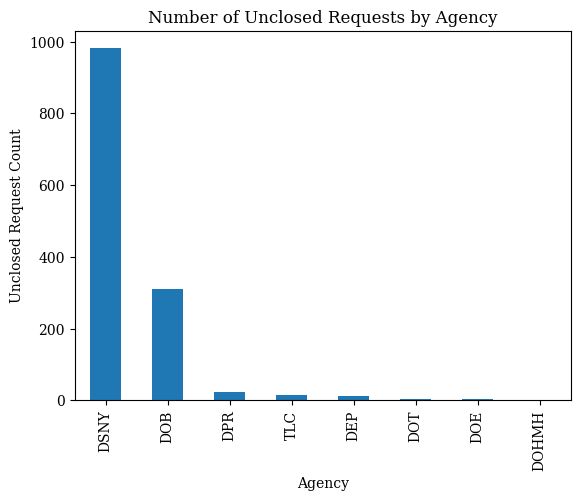

In [104]:
unclosed = df[df["status"]!="Closed"]["agency"].value_counts()
unclosed.plot.bar(title="Number of Unclosed Requests by Agency", xlabel="Agency", ylabel="Unclosed Request Count")

In [105]:
# cl_hr_1 = df["closed_date"].groupby([df["closed_date"].dt.date, df["closed_date"].dt.hour]).value_counts().cumsum()
# conver to hours
# create cumulative sum by summing value count by date for closed date and created date
# subtract the series of cumsums from each other to get number of open per hour

In [106]:
def add_created_count_feat(df:pd.DataFrame,
                           features:list[str],
                           inplace = False):
    trunc_name = "_".join(["created"]+[name[:2] for name in features])
    created_by_date = df.groupby(
    by=[
        pd.to_datetime(df["created_date"].astype("int64")).dt.floor("H"),
        *features
        ]
    )["created_date"].count()

    # ab["time"] = pd.to_datetime(ab["created_date"].astype(str)+" "+ab["hour"].astype(str)+":00:00")
    # ab.drop(["created_date", "hour"], axis=1, inplace=True)
    # ab.set_index("time", inplace=True)
    if not inplace:
        return created_by_date.unstack().fillna(0)
    else:
        df.set_index([
            pd.to_datetime(df["closed_date"].astype("int64")).dt.floor("H"),*features
            ], inplace=True)
        df[trunc_name] = created_by_date.fillna(0)


add_created_count_feat(df, ["agency", "borough"])

borough                     BRONX  BROOKLYN  MANHATTAN  QUEENS  STATEN ISLAND  \
created_date        agency                                                      
2018-04-13 18:00:00 DCA         3         0          0       0              1   
                    DEP         2         9          5       7              2   
                    DHS         1         1          0       1              0   
                    DOB         3         7          1       3              0   
                    DOHMH       0         0          2       0              0   
...                           ...       ...        ...     ...            ...   
2018-12-31 23:00:00 DPR         0         1          0       0              0   
                    DSNY        0         3          0       4              0   
                    HPD        13        18          9       2              0   
                    NYPD       39        43         24      37              4   
                    TLC         0         0          2       1              0   

borough                     Unspecified  
created_date        agency               
2018-04-13 18:00:00 DCA               0  
                    DEP               0  
                    DHS               0  
                    DOB               0  
                    DOHMH             0  
...                                 ...  
2018-12-31 23:00:00 DPR               0  
                    DSNY              0  
                    HPD               0  
                    NYPD              0  
                    TLC               0  

[70878 rows x 6 columns]

In [107]:
    # categories = []
    # for c in features:
    #     categories.append(df[c].unique())

    # d_idx = pd.date_range(df['created_date'].min(), df['closed_date'].max(), freq="H", name="time")
    # idx = pd.MultiIndex.from_product([d_idx, *categories], names=["created_date", *features])
    # t_num_created = t_num_created.reindex(t_num_closed.index, method='ffill')
    # t_num_closed = t_num_closed.reindex(t_num_created.index, method='ffill')



    # calculate number open at that time
    # diff = t_num_created - t_num_closed
    # diff = diff.reindex(df.index)

In [123]:
def add_open_count_feat(df:pd.DataFrame, features:list[str]):
    # col name for new feature
    trunc_name = "_".join(["open"]+[name[:2] for name in features])


    # set the index to features and date closed
    # df.set_index(pd.to_datetime(df["created_date"].astype("int64")).dt.floor("H"), inplace=True)
    # # df.set_index(pd.to_datetime(df["closed_date"].astype("int64")).dt.floor("H"), inplace=True, append=True)
    # df.set_index(features, inplace=True, append=True)
    df["created_hour"] = pd.to_datetime(df["created_date"].astype("int64")).dt.floor("H")
    df["closed_hour"] = pd.to_datetime(df["closed_date"].astype("int64")).dt.floor("H")
    df.set_index(['closed_hour']+features, inplace = True)

    # sort by closed date
    df.sort_index(axis=0, level='closed_hour', ascending=True, inplace=True)

    # count number closed per hour
    t_num_closed = df["closed_date"].groupby(level=list(range(df.index.nlevels))).count()
    t_num_closed:pd.Series = t_num_closed[t_num_closed.index.get_level_values('closed_hour') < df['created_hour'].max()]
    t_num_closed = t_num_closed.unstack(level=features, fill_value=0).cumsum()

    # remove closed date from index
    df.reset_index("closed_hour", drop=True, inplace=True)
    df.reset_index(features, drop=False, inplace=True)

    # Add created date to index
    df.set_index(['created_hour']+features, inplace = True)
    df.sort_values(by="created_hour", ascending=True, inplace=True)

    t_num_created = df["created_date"].groupby(level=list(range(df.index.nlevels))).count()
    # unstack to get columns for all features
    # get cumsum over the features then restack into a series
    t_num_created = t_num_created.unstack(level=features, fill_value=0).cumsum()
    #.stack(level=features)
    # print(t_num_closed.index.names)
    # print(t_num_created.index.names)

    t_num_closed.index.rename('created_hour', inplace=True)
    missing_indices = t_num_closed.index.union(t_num_created.index)
    # print(missing_indices)
    extra_indices = t_num_closed.index.difference(t_num_created.index)
    t_num_closed = t_num_closed.reindex(missing_indices, method='ffill')
    t_num_closed = t_num_closed[~t_num_closed.index.isin(extra_indices)].fillna(0)

    t_num_closed = t_num_closed.stack(level=features)
    t_num_created = t_num_created.stack(level=features)

    # change index to be more like created_date
    # print(t_num_closed.index.names)
    # print(t_num_created.index.names)
    # t_num_closed = t_num_closed.reindex_like(t_num_created, method='ffill')#.unstack(level=features).ffill().fillna(0).stack(level=features)
    # display(t_num_created)
    # display(t_num_closed)
    # print(len(t_num_closed)-len(t_num_created))
    # both series have identidcal indices, no null elements, and matching datatypes
    diff:pd.Series = (t_num_created-t_num_closed)
    diff = diff.reorder_levels(df.index.names)
    # display(diff)
    # df.set_index(pd.to_datetime(df["closed_date"].astype("int64")).dt.floor("H"), inplace=True, append=True)
    df[trunc_name] = diff
    df.reset_index(features, inplace=True)
    df.reset_index("created_hour", drop=True, inplace=True)



In [124]:
# calculate number of open requests divided by a powerset of s
s = ["borough", "agency","complaint_type"]
try:
    for c in chain.from_iterable(combinations(s, r) for r in range(len(s)+1)):
        if c == ():
            continue
        c = list(c)
        add_open_count_feat(df, c)
except Exception as e:
    display(df)

    df.reset_index(c, inplace=True)
    df.reset_index(drop=True,inplace=True)

    raise e
df

DatetimeIndex(['2018-04-13 18:00:00', '2018-04-13 19:00:00',
               '2018-04-13 20:00:00', '2018-04-13 21:00:00',
               '2018-04-13 22:00:00', '2018-04-13 23:00:00',
               '2018-04-14 00:00:00', '2018-04-14 01:00:00',
               '2018-04-14 02:00:00', '2018-04-14 03:00:00',
               ...
               '2018-12-31 14:00:00', '2018-12-31 15:00:00',
               '2018-12-31 16:00:00', '2018-12-31 17:00:00',
               '2018-12-31 18:00:00', '2018-12-31 19:00:00',
               '2018-12-31 20:00:00', '2018-12-31 21:00:00',
               '2018-12-31 22:00:00', '2018-12-31 23:00:00'],
              dtype='datetime64[ns]', name='created_hour', length=6294, freq='H')
DatetimeIndex(['2018-04-13 18:00:00', '2018-04-13 19:00:00',
               '2018-04-13 20:00:00', '2018-04-13 21:00:00',
               '2018-04-13 22:00:00', '2018-04-13 23:00:00',
               '2018-04-14 00:00:00', '2018-04-14 01:00:00',
               '2018-04-14 02:00:00', '2018-

,borough,agency,complaint_type,created_date,closed_date,status,resolution_action_updated_date,descriptor,resolution_description,incident_zip,...,due_date,bbl,hours_to_complete,open_bo,open_ag,open_bo_ag,open_co,open_bo_co,open_ag_co,open_bo_ag_co
0,BRONX,NYPD,Animal Abuse,2018-04-13 18:22:30,2018-04-13 18:36:30,Closed,2018-04-13 18:36:30,Tortured,Your request can not be processed at this time...,10458,...,2018-04-14 02:22:30,2031590007,0.233333,40,104,20,3,0,3,0
1,STATEN ISLAND,NYPD,Illegal Parking,2018-04-13 18:59:57,2018-04-13 21:51:50,Closed,2018-04-13 21:51:50,Blocked Sidewalk,The Police Department issued a summons in resp...,10304,...,2018-04-14 02:59:57,5004890005,2.864722,16,104,3,21,2,21,2
2,QUEENS,NYPD,Vending,2018-04-13 18:49:14,2018-04-14 19:52:26,Closed,2018-04-14 19:52:26,Unlicensed,The Police Department responded to the complai...,11104,...,2018-04-14 02:49:14,<NA>,25.053333,55,104,22,2,1,2,1
3,BRONX,DOB,General Construction/Plumbing,2018-04-13 18:16:16,2018-04-16 00:00:00,Closed,2018-04-16 00:00:00,"Building - Vacant, Open And Unguarded",The Department of Buildings determined that th...,10460,...,<NA>,2029560039,53.728889,40,14,3,7,2,7,2
4,BROOKLYN,DOB,Special Projects Inspection Team (SPIT),2018-04-13 18:55:48,2018-04-16 00:00:00,Closed,2018-04-16 00:00:00,Illegal Hotel Rooms In Residential Building,The Department of Buildings reviewed this comp...,11232,...,<NA>,3007180039,53.070000,73,14,7,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1886364,QUEENS,NYPD,Noise - Residential,2018-12-31 23:10:19,2019-01-01 01:06:02,Closed,2019-01-01 01:06:02,Loud Music/Party,The Police Department responded to the complai...,11375,...,2019-01-01 07:10:19,4032620063,1.928611,19795,953,141,326,32,326,32
1886365,QUEENS,NYPD,Noise - Street/Sidewalk,2018-12-31 23:41:51,2019-01-01 01:37:38,Closed,2019-01-01 01:37:38,Loud Music/Party,The Police Department responded to the complai...,11377,...,2019-01-01 07:41:51,4022950083,1.929722,19795,953,141,64,4,64,4
1886366,BRONX,NYPD,Noise - Residential,2018-12-31 23:52:52,2019-01-01 02:32:06,Closed,2019-01-01 02:32:06,Loud Music/Party,The Police Department responded to the complai...,10468,...,2019-01-01 07:52:52,2033150098,2.653889,14885,953,172,326,82,326,82
1886367,BROOKLYN,NYPD,Blocked Driveway,2018-12-31 23:10:48,2019-01-01 02:50:28,Closed,2019-01-01 02:50:28,Partial Access,The Police Department responded and upon arriv...,11218,...,2019-01-01 07:10:48,3052900020,3.661111,28979,953,138,177,37,177,37


In [ ]:
df

In [ ]:
df.groupby()

In [125]:
# average completion time
completion_time_by_type = df.groupby("complaint_type")["hours_to_complete"].mean()
# number of complaint types
num_of_type = df.groupby("complaint_type")["complaint_type"].value_counts()

In [126]:
bin_lbls = ["Low","Mid","High"]
# binning freqency of complaint
q1, bins = pd.qcut(num_of_type, 3, labels=bin_lbls, retbins=True,duplicates="raise")
candidates = q1[q1=="High"].index
# binning completion time
# q2, bins = pd.qcut(completion_time_by_type[completion_time_by_type.index.isin(candidates)], 3, labels=bin_lbls, retbins=True,duplicates="raise")

In [ ]:
df.columns

In [131]:

# get high frequency records
high_freq_df = df[(df["created_date"]>df["created_date"].median())&(df["complaint_type"].isin(candidates))]

# row key: [correlation, y_column, [x_columns]]
high_corr = {}
# visited = {}
# minimum absolute correlation to be added to the dict
min_corr = 0.3
for col_names in chain.from_iterable(combinations(s, r) for r in range(len(s)+1)):
    if col_names == ():
        continue
    trunc_name = "_".join(["open"]+[name[:2] for name in col_names])
    col_names = list(col_names)
    # get the correlation between completion time and number open for high freq
    consider_df = high_freq_df.groupby(col_names)[["hours_to_complete",trunc_name]]
    correlation:pd.DataFrame = consider_df.corr()
    correlation.drop(trunc_name, axis=1, inplace=True)
    correlation.reset_index(level=-1, drop=True, inplace=True)
    abs_correlation = correlation["hours_to_complete"].abs().iloc[1::2]
    # display(abs_correlation)
    hcorr:pd.Series = abs_correlation[(abs_correlation<1)&(abs_correlation>min_corr)]

    for n, v in hcorr.items():
        tdic = {k:v for k, v in zip(col_names, n)}
        if consider_df.get_group(n)["hours_to_complete"].count() < 1000:
            continue
        if "complaint_type" in tdic and tdic["complaint_type"] in high_corr:
            continue
        if n not in high_corr:
            high_corr[n] = [v, trunc_name, col_names]
        else:
            high_corr[n] = max(high_corr[n], [v, trunc_name, col_names])
# select complaint types whose completion time is dependent on number of open requests
# high_freq_df = high_freq_df[high_freq_df["complaint_type"].isin(high_corr)]


high_corr

{'DFTA': [0.308960097523828, 'open_ag', ['agency']],
 'HRA': [0.4961674336632226, 'open_ag', ['agency']],
 'Benefit Card Replacement': [0.4961674336632226,
  'open_co',
  ['complaint_type']],
 'DOF Property - Reduction Issue': [0.3915567377531986,
  'open_co',
  ['complaint_type']],
 'Housing - Low Income Senior': [0.39926254714531517,
  'open_co',
  ['complaint_type']],
 'SCRIE': [0.6280286997260807, 'open_co', ['complaint_type']],
 ('Unspecified', 'HRA'): [0.4961674336632226,
  'open_bo_ag',
  ['borough', 'agency']]}

In [141]:
# remove outlier records
upper = high_freq_df.groupby("complaint_type")["hours_to_complete"].quantile(0.99)
high_freq_df = pd.merge(high_freq_df, upper.rename('upper_bound'), left_on="complaint_type", right_index=True)
high_freq_df = high_freq_df[high_freq_df["hours_to_complete"] < high_freq_df["upper_bound"]]
high_freq_df.drop("upper_bound", axis=1, inplace=True)

In [ ]:
df.loc[(df["borough"]=="BRONX") & (df["complaint_type"] == "Graffiti")]

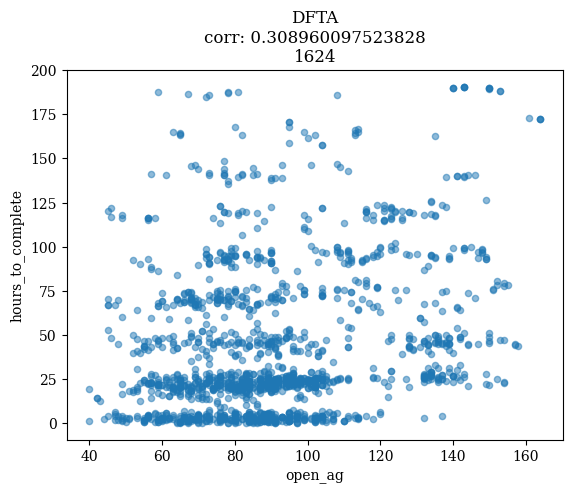

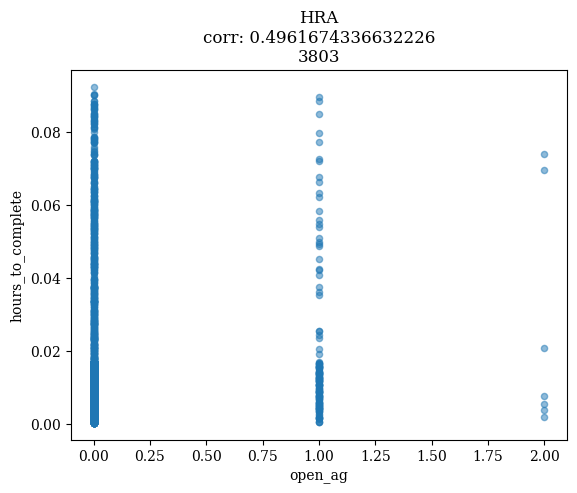

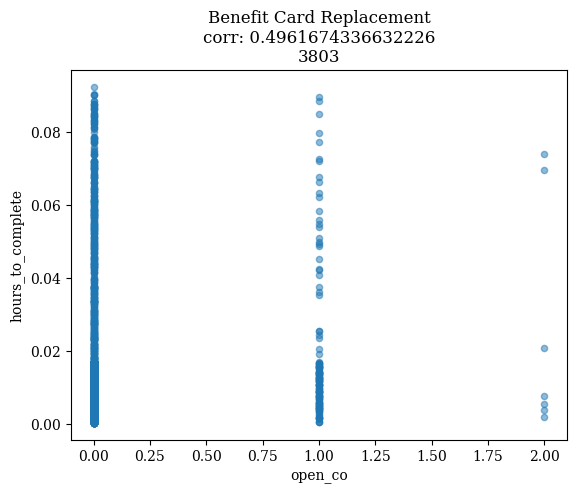

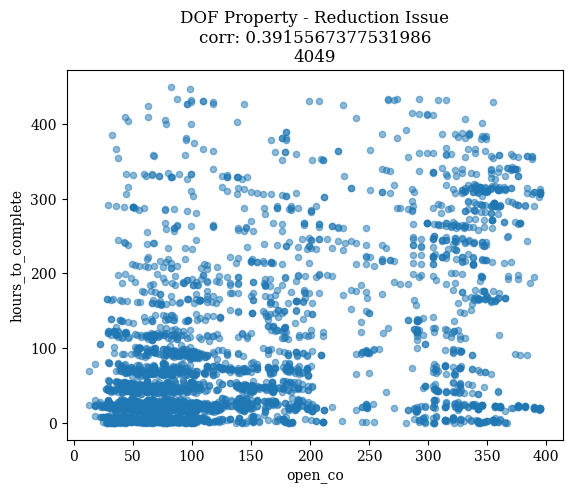

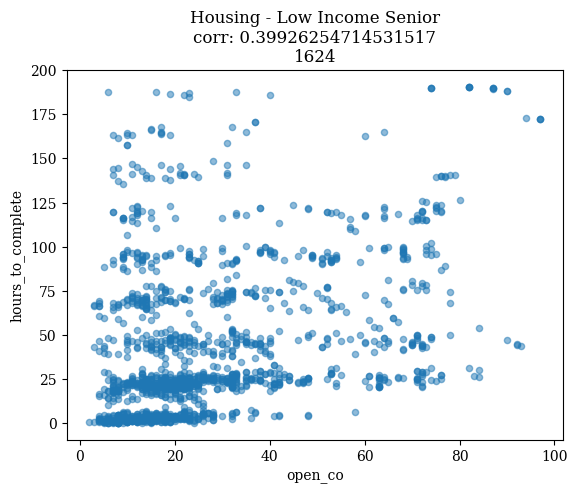

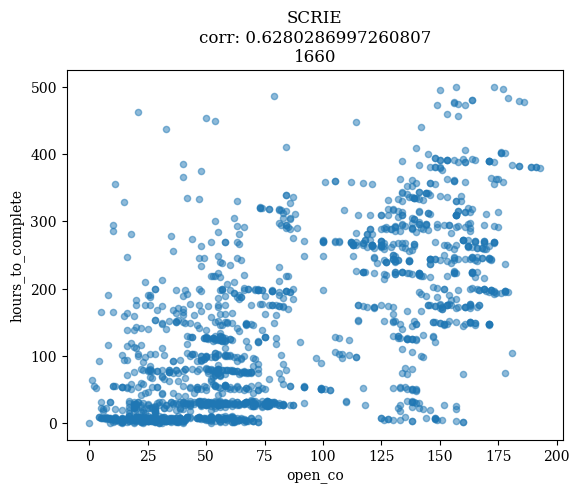

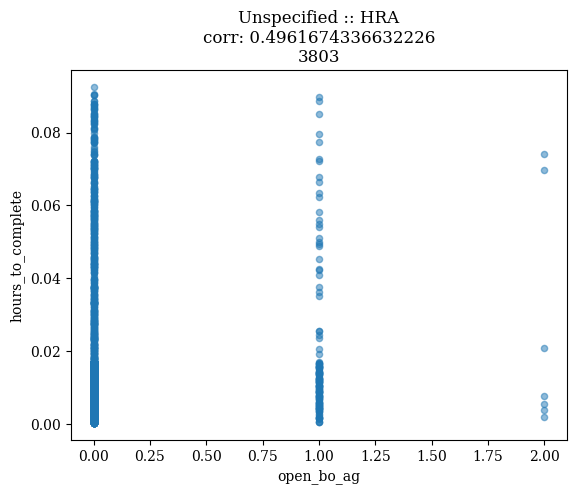

In [143]:
# graph hexbins for high corr, high frequency complaint types
for n, (corr, x, c) in high_corr.items():
    try:
        grp = high_freq_df.groupby(c).get_group(n)
    except KeyError:
        continue
    # if len(grp) < 2000:
    #     continue
    if isinstance(n, tuple):
        name = ' :: '.join(n)
    else:
        name = n
    grp.plot.scatter(
        y="hours_to_complete",
        x=x,
        # gridsize=[500,500],
        alpha=0.5,
        # ylim=[0,500],
        # gridsize=50
        # cmap="viridis",
        title=f"{name}\ncorr: {corr}\n{len(grp)}")


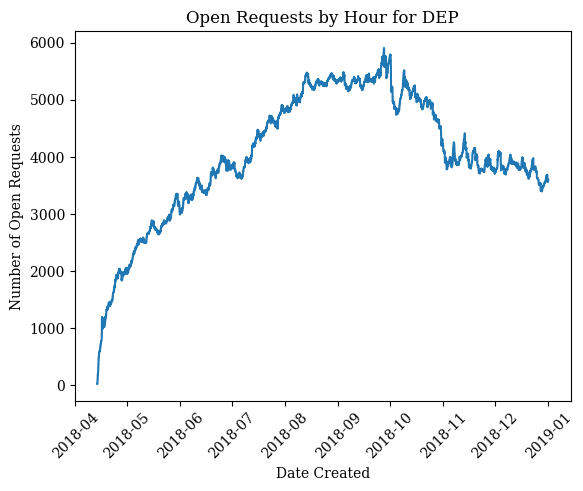

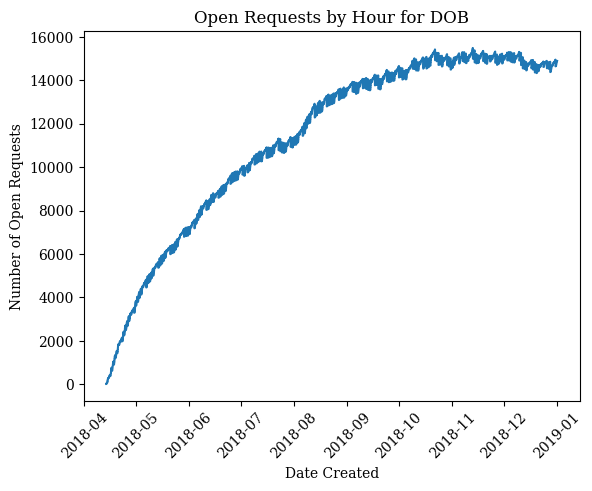

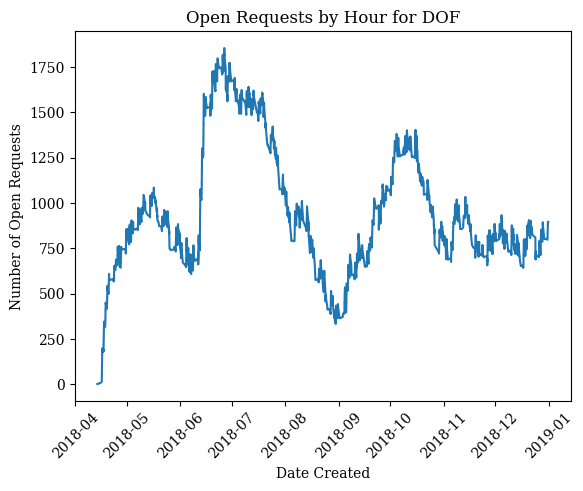

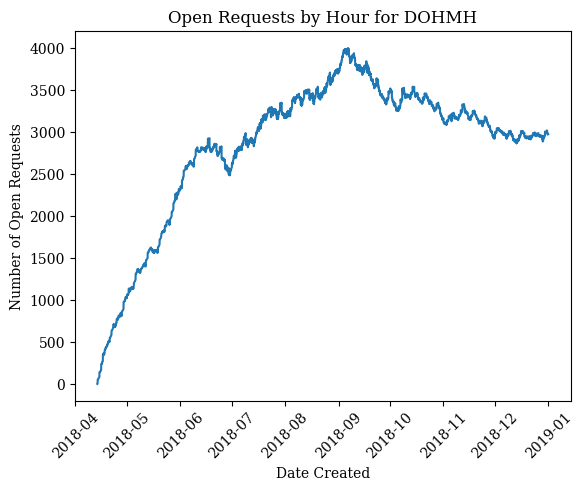

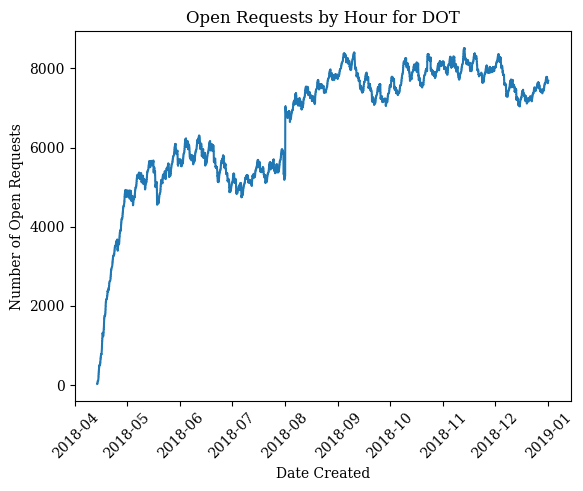

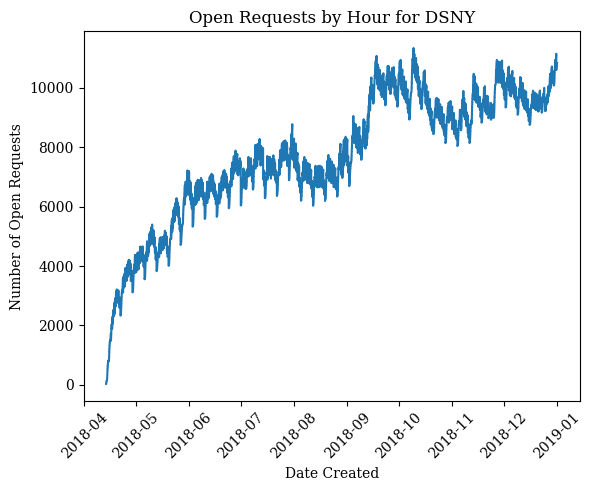

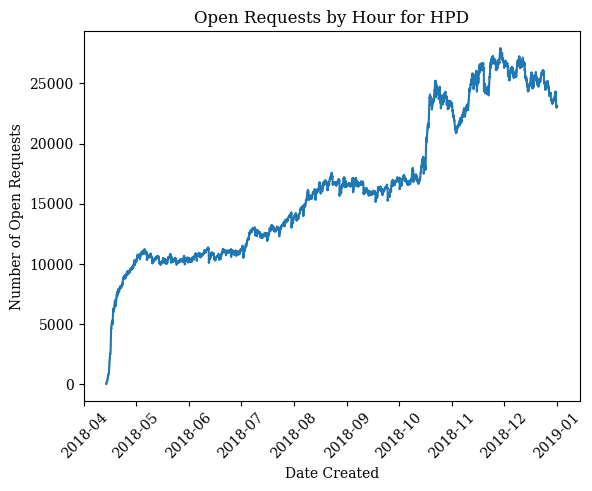

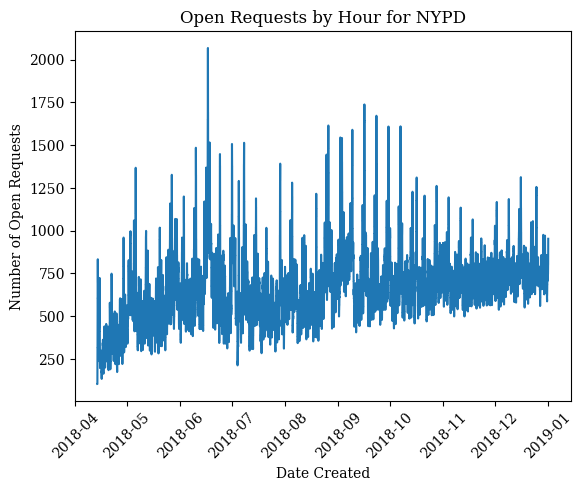

In [144]:
# graph number of open requests by agency for the sample
# df[df["open_bo"]>0].groupby("borough").plot(x="created_date", y="open_bo")
high_freq = ['HPD', 'NYPD', 'DSNY', 'DOT', 'DEP', 'DOB', 'DOF', 'DOHMH']
for n, grp in df[df["agency"].isin(high_freq)].groupby(["agency"]):
    # forward fill for missing days and fill first day w/ 0
    grp['open_ag'] = grp['open_ag'].ffill().fillna(0)
    ax = grp.plot(x="created_date", y='open_ag', title=f"Open Requests by Hour for {n[0]}", legend= False)
    ax.set_xlabel("Date Created")
    ax.set_ylabel("Number of Open Requests")
    ax.tick_params(axis='x',rotation=45)


In [ ]:
df = df.dropna(axis=0)


In [ ]:
# df.columns = ['borough', 'agency', 'created_date', 'closed_date', 'complaint_type',
#        'status', 'resolution_action_updated_date', 'descriptor',
#        'resolution_description', 'incident_zip', 'city', 'latitude',
#        'longitude', 'due_date', 'bbl', 'hours_to_complete', 'open',
#        'open_ag_br', 'open_ag', 'open_br']
df.columns = [
       'borough', 'agency',
       'ds', 'closed_date',
       'complaint_type', 'status',
       'resolution_action_updated_date', 'descriptor',
       'resolution_description', 'incident_zip',
       'city', 'latitude',
       'longitude', 'due_date',
       'bbl', 'hours_to_complete',
       'open', 'y',
       'open_ag', 'open_br'
]


In [ ]:
# heirarchies = [
#     ["borough"],
#     [ "borough","incident_zip"],
#     [ "borough","incident_zip", "agency"],
#     [ "borough","incident_zip", "agency", "complaint_type"],
# ]
hdf = df[df["borough"]!= "Unspecified"]
bdf, H_df, tags = aggregate(
    hdf,
    spec=[["agency","borough"]]
)

In [ ]:
bdf

In [ ]:
hrec = HierarchicalReconciliation(
    reconcilers =
        [
            MinTrace("ols", nonnegative=True,num_threads=-1),
            # ERM("closed"),
            # BottomUp()
        ]
)


In [ ]:


Y_df = bdf[(bdf['ds']>datetime.date(year=2018, month=10, day=1)) & (bdf['ds']<datetime.date(year=2018, month=12, day=1))]
Y_df

In [ ]:

models = [MSTL(
    season_length=[24, 24 * 7], # seasonalities of the time series
    trend_forecaster=AutoARIMA(trace=True) # model used to forecast trend
)]
sf = StatsForecast(
    models = models,
    freq = 'H',
    df=Y_df,
    n_jobs=-1
    )
sf.fit()

In [ ]:
fcts  = sf.forecast(h=1,df=bdf, level=[90])

In [ ]:
fcts

In [ ]:
StatsForecast.plot(df=Y_df, forecasts_df=fcts[fcts.index.isin(bdf.index)].fillna(0))